In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam 
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalMaxPooling2D, Flatten, Concatenate 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.inception_resnet_v2 import InceptionResNetV2

%matplotlib inline

Using TensorFlow backend.


In [18]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import auc
from utils.tester import run_test

### Data Generator

In [4]:
data_dir = './data/macenko/'

In [5]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=None, val_limit=None, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [6]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [7]:
del train_id
del val_id
del data_dir

## MODEL

In [8]:
def build_arch_8_net():
    
    inputs = Input((96,96,3))
    inception = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=inputs)
    
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities
    model = Model(inputs=inception.input, outputs=y)
    
    for layer in inception.layers:
        layer.trainable = False

    return model

In [9]:
model = build_arch_8_net()

W0616 22:39:10.598036 140479847030912 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0616 22:39:10.610573 140479847030912 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0616 22:39:10.612358 140479847030912 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0616 22:39:10.623564 140479847030912 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_b

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 47, 47, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 47, 47, 32)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 47, 47, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

### Compile

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_auc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [12]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['acc', auc]

In [13]:
model.compile(optimizer, loss, metrics)

W0616 22:39:30.752504 140479847030912 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0616 22:39:30.757575 140479847030912 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3378: The name tf.nn.sigmoid_cross_entropy_with_logits is deprecated. Please use tf.nn.sigmoid_cross_entropy_with_logits instead.

W0616 22:39:30.759000 140479847030912 deprecation.py:323] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:179: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0616 22:39:30.772

#### Load Model

## Train the model

In [14]:
model_name = 'inception_model_bin_cross_arch_8_lr_0_001_inp96'

In [15]:
batch_size = 128
n_epoch = 15

# Parameters for generators
train_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)


# Callbacks
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]

In [16]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

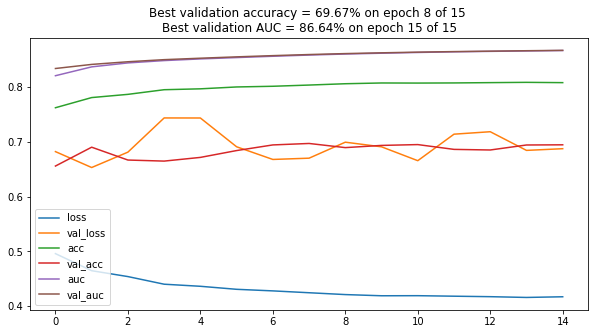


Epoch 00015: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.


In [17]:
# Training - limitless - macenko - augmented
model.fit_generator(training_generator, validation_data=validation_generator,
                    epochs=n_epoch, callbacks=callbacks)

In [20]:
run_test('./Model/inception_model_bin_cross_arch_8_lr_0_001_inp96/inception_model_bin_cross_arch_8_lr_0_001_inp96_epoch_15.h5')

sklearn auc: 0.7373130940956683
tf auc: [0.73727524, 0.73727524]
